In [11]:
from Predict_lc import PredictLightCurve

In [12]:
import numpy as np
from dataframe import Data
from io_utils import *
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
import pandas as pd

In [13]:
from ipywidgets import FloatProgress
from tqdm.notebook import tqdm

In [14]:
dataset = "ZTF"
train_ob = load_ztf_train_data(head_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_master_HEAD.FITS', phot_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_master_PHOT.FITS')
test_ob = load_ztf_test_data(head_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_master_HEAD.FITS', phot_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_master_PHOT.FITS')

train_object_ids = train_ob.get_all_object_ids()
train_kilonova_ids = train_ob.get_ids_of_event_type([150,151])
train_ob.df_data.sort(['SNID','MJD'])
train_ob.df_metadata.sort(['SNID'])

test_object_ids = test_ob.get_all_object_ids()
test_kilonova_ids = test_ob.get_ids_of_event_type(150)
test_kilonova_ids = vstack([test_kilonova_ids, test_ob.get_ids_of_event_type(151)])
test_kilonova_ids = test_kilonova_ids['SNID']
test_ob.df_data.sort(['SNID','MJD'])
test_ob.df_metadata.sort(['SNID'])

bands = ['g', 'r']
color_band_dict = {'g':'C2', 'r':'C3'}

In [15]:
print(train_kilonova_ids)

   SNID  
---------
 17079528
 16574534
 22145989
  1562696
  8719818
 20292655
 15771916
  7516833
  1952056
  2579381
      ...
  2472236
129778492
 99736043
 17865701
 13869993
 42987151
 19564018
 67826061
 48139199
 52579122
  3577952
Length = 2780 rows


In [ ]:
def multi_mrocessor():
    coeff_dict, num_pts_dict = pc.predict_lc_coeff(current_date=current_date,num_pc_components=num_pc_components, decouple_pc_bands=decouple_pc_bands, decouple_prediction_bands=decouple_prediction_bands, min_flux_threshold=min_flux_threshold, bands=bands)
        

In [ ]:
def create_features_df(data_ob, decouple_prediction_bands=True, decouple_pc_bands=False, mark_maximum=False, min_flux_threshold=20, num_pc_components=3, use_random_current_date= False, plot_prediction = False):
    data_dict = {'id':[],
                 'type':[],}
    
    object_ids = data_ob.get_all_object_ids()
    #data_object_ids = np.random.permutation(data_object_ids)
    data_ob.df_data.sort([data_ob.object_id_col_name,data_ob.time_col_name])
    for object_id in tqdm(object_ids):
        event_df = data_ob.get_data_of_event(object_id)
        #print(event_df['FLT'])
        pc = PredictLightCurve(data_ob, object_id=object_id)
        #print(pc.lc.df['FLT'])
        #print(pc.lc.band_map.items())
        #print("------------")
        current_date = None
        if use_random_current_date:
            median_date = np.median(pc.lc.dates_of_maximum)
            current_date = median_date+random()*50-25
            
        coeff_dict, num_pts_dict = pc.predict_lc_coeff(current_date=current_date,num_pc_components=num_pc_components, decouple_pc_bands=decouple_pc_bands, decouple_prediction_bands=decouple_prediction_bands, min_flux_threshold=min_flux_threshold, bands=bands)
        data_dict['id'].append(object_id)
        #print(data_dict['object_id'])
        for i,band in enumerate(bands):
            for j in range(1,num_pc_components+1):
                col_name = str(i)+'pc'+str(j)
                if col_name not in data_dict.keys():
                    data_dict[col_name] = []
                data_dict[col_name].append(coeff_dict[band][j-1])
            col_name = str(i)+'n'
            if col_name not in data_dict.keys():
                    data_dict[col_name] = []
            data_dict[col_name].append(num_pts_dict[band])
        object_type = data_ob.get_object_type_number(object_id)
        data_dict['type'].append(object_type)
        if plot_prediction:
            fig = pc.plot_predicted_bands(all_band_coeff_dict=coeff_dict, color_band_dict=color_band_dict, mark_maximum=mark_maximum,axes_lims = False)
            plt.show()
            plt.close('all')

    data_df = pd.DataFrame(data_dict)
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    return data_df
        

In [ ]:
train_df = create_features_df(train_ob)
test_df = create_features_df(test_ob)

In [ ]:
print(train_df)

In [ ]:
train_df.to_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features_master.csv', index=False)
test_df.to_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_features_master.csv', index=False)

# Load saved data

In [16]:
train_df = pd.read_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features_master.csv')
test_df = pd.read_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_features_master.csv')

In [17]:
prediction_type = [150,151]

In [18]:
print(np.sum(train_df['type']==151))

2000


In [19]:
def sample_from_df(train_df, sample_number, shuffle=False):
    final_df =None
    for key,value in sample_number.items():
        if value == 0:
            continue
        #print(key)
        current_type_df = train_df[train_df['type'] ==key]
        len_current_df = len(current_type_df)
        if len_current_df==0:
            print("event type not found")
        #current_type_ids = train_df['ids'].values
        #current_type_ids = np.random.shuffle(current_type_ids)
        #selected_ids = current_
        #print(len(current_type_df))
        if value>len_current_df:
            value = len_current_df
            sample_number[key]=len_current_df
        current_type_df = current_type_df.sample(value)
        #print(current_type_df)
        if final_df is None:
            final_df=current_type_df
        else:
            final_df= pd.concat([final_df, current_type_df], ignore_index=True)
    if shuffle:
        final_df = final_df.sample(frac=1).reset_index(drop=True)
    return final_df

In [20]:
sample_numbers_train = {101:150, 
               102:150, 
               103:150, 
               112:150, 
               113:150, 
               114:150, 
               141:150, 
               143:1500, 
               145:2500, 
               150:2500, 
               151:2500, 
               160:150, 
               161:150, 
               162:150, 
               163:150, 
               164:150, 
               170:0, 
               180:0, 
               181:0, 
               183:0, 
               190:0}
train_df= sample_from_df(train_df,sample_numbers_train,shuffle=True)

In [21]:
sample_numbers_test = {101:150, 
               102:150, 
               103:150, 
               112:150, 
               113:150, 
               114:150, 
               141:150, 
               143:150, 
               145:150, 
               150:2500, 
               151:2500, 
               160:150, 
               161:150, 
               162:150, 
               163:150, 
               164:200, 
               170:0, 
               180:0, 
               181:0, 
               183:0, 
               190:0}
test_df= sample_from_df(test_df,sample_numbers_test,shuffle=True)

In [22]:
def add_y_val(data_df, data_ob, prediction_type):
    data_df['y'] = data_df['id'].map(lambda ob_id: 1 if data_ob.get_object_type_number(ob_id) in prediction_type else 0)
    return data_df

In [23]:
train_df = add_y_val(train_df, data_ob=train_ob, prediction_type=prediction_type )
test_df = add_y_val(test_df, data_ob=test_ob, prediction_type=prediction_type)

In [24]:
print(np.sum([train_df['y'].values==1]))

2780


In [25]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Train classifier

In [26]:
num_pc_components = 3

cols = []
for i,band in enumerate(bands):
    for j in range(1,num_pc_components+1):
        col_name = str(i)+'pc'+str(j)
        cols.append(col_name)
        
x_train = train_df[cols].values
y_train = train_df['y'].values

x_test = test_df[cols].values
y_test = test_df['y'].values

In [27]:
x_train.shape

(6580, 6)

In [28]:
print(y_test)

[1 1 1 ... 0 1 1]


In [29]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)

clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)
y_score= clf.predict_proba(x_test)

In [30]:
true_index = y_test ==1
y_test_true = y_test[true_index]
y_pred_true = y_pred[true_index]
print(np.sum(y_test_true))
print(np.sum(y_pred_true))

1788
1448


In [31]:
print(y_score[:,1])

[0.68 0.67 0.78 ... 0.   0.74 0.48]


In [32]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8654139156932453


In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])
roc_auc = metrics.auc(fpr, tpr)

In [34]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr,tpr,roc_auc, ax):
    #fig = plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')

    plt.ylim([0, 1])
    plt.xlim([0, .1])
    #plt.axis("square")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.gca().set_aspect("equal")
    return fig
    #plt.show()
    #plt.close('all')

In [35]:
print(metrics.confusion_matrix(y_test, y_pred))

[[1960  190]
 [ 340 1448]]


In [36]:
prediction_stat={}
for i,object_id in enumerate(test_df['id']):
    if isinstance(prediction_type, int):
        prediction_type = [prediction_type]
    #print(i)
    type_no = test_ob.get_object_type_number(object_id)
    if sample_numbers_train[type_no] == 0:
        type_no = 0
    
    if type_no not in prediction_stat:
        prediction_stat[type_no] = [0,1]
    else: 
        prediction_stat[type_no][1] = prediction_stat[type_no][1] + 1
    
    if (type_no in prediction_type) & (y_pred[i] ==1):
        prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

    elif (y_pred[i]==0)&(type_no not in prediction_type):
        prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

In [37]:
def get_stat_df(data_ob, result_df, prediction_type, y_pred, sample_numbers_train):
    prediction_stat={}
    for i,object_id in enumerate(result_df['id']):
        if isinstance(prediction_type, int):
            prediction_type = [prediction_type]
        #print(i)
        type_no = data_ob.get_object_type_number(object_id)
        num_training_events = sample_numbers_train[type_no]
        if num_training_events == 0:
            type_no = 0

        if type_no not in prediction_stat:
            prediction_stat[type_no] = [0,1,num_training_events]
        else: 
            prediction_stat[type_no][1] = prediction_stat[type_no][1] + 1

        if (type_no in prediction_type) & (y_pred[i] ==1):
            prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

        elif (y_pred[i]==0)&(type_no not in prediction_type):
            prediction_stat[type_no][0]=prediction_stat[type_no][0]+1
    stat_df = pd.DataFrame(prediction_stat) 
    return stat_df.reindex(sorted(stat_df.columns), axis=1)


In [38]:
df_stat= get_stat_df(test_ob,test_df, prediction_type,y_pred, sample_numbers_train=sample_numbers_train)

In [39]:
#test_stat_df= get_stat_df(test_ob,test_df, prediction_type,y_pred)

In [40]:
df_stat

,101,102,103,112,113,114,141,143,145,150,151,160,161,162,163,164
0,146,147,141,147,134,143,83,146,81,650,798,149,150,150,145,198
1,150,150,150,150,150,150,150,150,150,788,1000,150,150,150,150,200
2,150,150,150,150,150,150,150,1000,1000,780,2000,150,150,150,150,150


In [41]:
print(df_stat)

   101  102  103  112  113  114  141   143   145  150   151  160  161  162  \
0  146  147  141  147  134  143   83   146    81  650   798  149  150  150   
1  150  150  150  150  150  150  150   150   150  788  1000  150  150  150   
2  150  150  150  150  150  150  150  1000  1000  780  2000  150  150  150   

   163  164  
0  145  198  
1  150  200  
2  150  150  


In [42]:
def ztf_ob_type_name(type_no):
    if type_no == 141:
        return '141: 91BG'
    if type_no == 143:
        return '143: Iax'
    if type_no == 145:
        return '145: point Ia'
    if type_no == 150:
        return '150: KN GW170817'
    if type_no == 151:
        return '151: KN Karsen 2017'
    if type_no == 160:
        return '160: Superluminous SN'
    if type_no == 161:
        return '161: pair instability SN'
    if type_no == 162:
        return '162: ILOT'
    if type_no == 163:
        return '163: CART'
    if type_no == 164:
        return '164: TDE'
    if type_no == 170:
        return '170: AGN'
    if type_no == 180:
        return '180: RRLyrae'
    if type_no == 181:
        return 'M 181: dwarf_flares'
    if type_no == 183:
        return '183: PHOEBE'
    if type_no == 190:
        return '190: uLens_BSR'
    if type_no == 191:
        return '191: uLens_Bachelet'
    if type_no == 192:
        return '192: uLens_STRING'     
    if type_no == 114:
        return '114: MOSFIT-IIn'
    if type_no == 113:
        return '113: Core collapse Type II using pca '
    if type_no == 112:
        return '112: Core collapse Type II'
    if type_no == 102:
        return '102: MOSFIT-Ibc'
    if type_no == 103:
        return '103: Core collapse Type Ibc'
    if type_no == 101:
        return '101: Ia SN'
    if type_no == 0:
        return '0: Unknown'


In [43]:
import matplotlib.gridspec as gridspec


In [44]:
def plot_confusion_matrix(ax, y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title =""

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    classes = [1,0]

    #fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize =15)
    #fig.tight_layout()
    ax.axis("equal")
    return ax

In [45]:
print(df_stat)

   101  102  103  112  113  114  141   143   145  150   151  160  161  162  \
0  146  147  141  147  134  143   83   146    81  650   798  149  150  150   
1  150  150  150  150  150  150  150   150   150  788  1000  150  150  150   
2  150  150  150  150  150  150  150  1000  1000  780  2000  150  150  150   

   163  164  
0  145  198  
1  150  200  
2  150  150  


In [46]:
def plot_contamination_statistics(df_stat,ax):
    #fig = plt.figure(figsize = (10,10))
    #ax = fig.add_axes([0,0,.9,.9])
    print(df_stat)

    col_type_nos = np.array(df_stat.columns)
    print(col_type_nos)
    pred_col_names = [ztf_ob_type_name(item) for item in prediction_type]
    non_pred_types = col_type_nos[~np.isin(col_type_nos,prediction_type )]
    print(pred_col_names)
    non_pred_type_names = [ztf_ob_type_name(item) for item in non_pred_types]
    col_type_names = [ztf_ob_type_name(item) for item in col_type_nos]
    print(col_type_nos)
    print(non_pred_types)
    
    print(np.where(np.in1d(non_pred_types,col_type_nos)))
    ax.barh(col_type_names,df_stat.loc[1],alpha=.6, tick_label= col_type_names,color='bisque',ec='black', linewidth=1, label="total number of events")
    ax.barh(non_pred_type_names, df_stat[non_pred_types].loc[0] , alpha=.6, color='red',ec='black', label='Correctly classified: class 0')
    ax.barh(pred_col_names, df_stat[prediction_type].loc[0], alpha=.6, color='chartreuse', ec='black',label='Correctly classified: class 1')
    plt.rc('ytick', labelsize=10) 
    plt.rc('xtick', labelsize=10)
    print(col_type_nos)
    for i, v in enumerate(col_type_nos):
        ax.text(df_stat[v].values[1]+10, i -.1, str(df_stat[v].values[0])+"/"+str(df_stat[v].values[1])+" | "+str(df_stat[v].values[2]), color='blue', fontweight='bold', fontsize=10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
    plt.xlim(right=np.max(df_stat.loc[1].values)*120/100)
    #plt.savefig('important_plots/correct_classifications_plot')
    #fig.tight_layout()
    #plt.xticks(rotation=90)
    #return fig
#plt.show()

In [58]:
def get_ignored_events(sample_numbers_train, sample_numbers_test):
    unknown = ""
    dropped = ""
    for key in sample_numbers_train:
        if sample_numbers_train[key] == 0:
            if sample_numbers_test[key] == 0:
                if dropped == "":
                    dropped = ztf_ob_type_name(key)
                else: 
                    dropped = dropped + ", "+ztf_ob_type_name(key)
            else:
                if unknown == "":
                    unknown = ztf_ob_type_name(key)
                else:
                    unknown = unknown + ", " +ztf_ob_type_name(key)
    if unknown == "":
        unknown = 'None'
    if dropped == "":
        dropped = 'None'
        
    return unknown,dropped

   101  102  103  112  113  114  141   143   145  150   151  160  161  162  \
0  146  147  141  147  134  143   83   146    81  650   798  149  150  150   
1  150  150  150  150  150  150  150   150   150  788  1000  150  150  150   
2  150  150  150  150  150  150  150  1000  1000  780  2000  150  150  150   

   163  164  
0  145  198  
1  150  200  
2  150  150  
[101 102 103 112 113 114 141 143 145 150 151 160 161 162 163 164]
['150: KN GW170817', '151: KN Karsen 2017']
[101 102 103 112 113 114 141 143 145 150 151 160 161 162 163 164]
[101 102 103 112 113 114 141 143 145 160 161 162 163 164]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)
[101 102 103 112 113 114 141 143 145 150 151 160 161 162 163 164]


/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


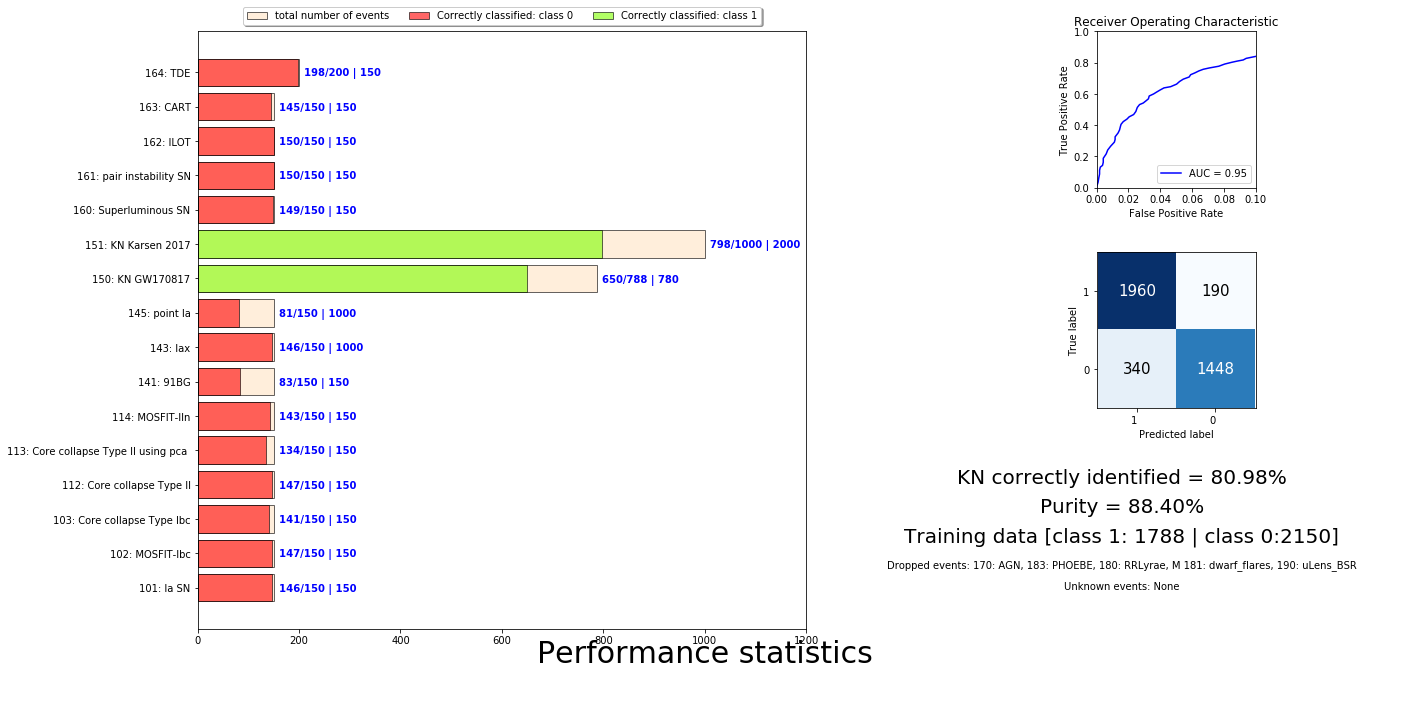

In [59]:
plt.close()
fig = plt.figure(figsize=(24,12))
#plt.subplot2grid((12,25), (0,0), colspan=25, rowspan=1, fig = fig)
#plt.title("performance statistics", loc = "center")
plt.subplot2grid((12,24), (0,3), colspan=11, rowspan=11, fig = fig)
plot_contamination_statistics(df_stat=df_stat,ax=plt.gca())
plt.subplot2grid((12,24),(0,19), rowspan=3, colspan=3, fig=fig)
plot_roc_curve(fpr=fpr,tpr=tpr, roc_auc=roc_auc, ax=plt.gca())
plt.subplot2grid((12,24),(4,19), rowspan=3, colspan=3, fig=fig)
plot_confusion_matrix(ax = plt.gca(), y_true=y_test,y_pred=y_pred,classes=['KN','NON-KN'])
cm = metrics.confusion_matrix(y_test,y_pred)
plt.annotate('KN correctly identified = '+str(100*cm[1][1]/(cm[1][0]+cm[1][1]))[:5]+"%",
            xy=(.79, .355), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)
plt.annotate('Purity = '+str(100*cm[1][1]/(cm[0][1]+cm[1][1]))[:5]+"%",
            xy=(.79, .315), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)
plt.annotate('Training data [class 1: '+ str(np.sum(df_stat[prediction_type].loc[1].values)) + " | class 0:"
             +str(np.sum(df_stat.loc[1].values)-np.sum(df_stat[prediction_type].loc[1].values))+"]",
            xy=(.79, .275), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)
#plt.annotate("Num trees ="+, )
plt.annotate('Performance statistics ',
            xy=(.5, .1), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center',
            fontsize=30)
unknown_events, dropped_events = get_ignored_events(sample_numbers_train, sample_numbers_test)
plt.annotate('Dropped events: '+dropped_events,
            xy=(.79, .23), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=10)
plt.annotate('Unknown events: '+unknown_events,
            xy=(.79, .20), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=10)
fig.tight_layout()
fig.savefig('Final_Results/case7')
plt.show()

### 91BG from S. Gonzalez-Gaitan and Felipe Lagos
141
### Iax from Saurabh
143
### pointIa
145
### - - - - - -  GW counterpart models - - - - - - - 
### Kilonova from GW170817
150
### Kilonova models from Kasen 2017
151
### - - - - - - - - - - - - - - - - - - - - - - - -
### Superluminous SN:  SLSN-I
160
### pair instability SN: PISN
161
### Intermediate Luminosity Optical Transients (ILOT)
162
### Ca Rich Transients (CART)
163 
### TDE
164
### - - - - - AGN - - - - - - 
170  
### - -- - - - - - - - - - - - - - - - - - - - - -
### Galactic transients
180  
181  
183  
190  
191
192
# - - - - - -
SNe
## MOSFIT-IIn  (4->14 on May 9 2018)
114 
### MOSFIT-Ibc (3->13 on May 9 2018)
113 
### Core collapse Type II using pca (5->12 on May 9 2018)
112
## - - - - - - - - - - - - - - - - - - - - - - - - - 
### Core collapse Type II from K10 templates
102
### Core collapse Type Ibc from K10 templates
103 
## Type Ia SN
101


BATCH_INFO:  sbatch  $SBATCH_TEMPLATES/SBATCH_sandyb.TEMPLATE 40
BATCH_MEM: 2000  # need more memory for som SIMSED models
PATH_SNDATA_SIM:  $SCRATCH_SIMDIR
# 91BG from S. Gonzalez-Gaitan and Felipe Lagos
#  (more templates than J17, and stretch-color correlation)
GENVERSION: ZTF_MSIP_MODEL41
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_91bg.INPUT
GENOPT: GENTYPE 41
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 4000

GENVERSION: ZTF_MSIP_MODEL43
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_Iax.INPUT
GENOPT: GENTYPE 43
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
----------------- pointIa -----------------------
GENVERSION:  ZTF_MSIP_MODEL45
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_pointIa.INPUT
GENOPT: GENTYPE 45
GENOPT: NGENTOT_LC 100000
# - - - - - -  GW counterpart models - - - - - - - 
# Kilonova from GW170817
GENVERSION:  ZTF_MSIP_MODEL50
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_KNova_GW170817.INPUT
GENOPT: GENTYPE 50
GENOPT: NGENTOT_LC 100000
# Kilonova models from Kasen 2017
GENVERSION:  ZTF_MSIP_MODEL51
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_KNova_Kasen2017.INPUT
GENOPT: GENTYPE 51
GENOPT: NGENTOT_LC 100000
# - - - - - - - - - - - - - - - - - - - - - - - -
# Superluminous SN:  SLSN-I
GENVERSION:  ZTF_MSIP_MODEL60
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_SLSN_MAGNETAR.INPUT
GENOPT: GENTYPE 60
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 200
# pair instability SN: PISN
GENVERSION:  ZTF_MSIP_MODEL61
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_PISN.INPUT
GENOPT: GENTYPE 61
GENOPT: SIMGEN_DUMP_PRESCALE 2
GENOPT: NGENTOT_LC 1000
# Intermediate Luminosity Optical Transients (ILOT)
GENVERSION:  ZTF_MSIP_MODEL62
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_ILOT.INPUT
GENOPT: GENTYPE 62
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 100000
# Ca Rich Transients (CART)
GENVERSION:  ZTF_MSIP_MODEL63
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_CART.INPUT
GENOPT: GENTYPE 63 
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 40000
# TDE
GENVERSION:  ZTF_MSIP_MODEL64
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_TDE.INPUT
GENOPT: GENTYPE 64
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 3000
# - - - - - AGN - - - - - - 
GENVERSION:  ZTF_MSIP_MODEL70
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_LSST-AGN.INPUT
GENOPT: GENTYPE 70   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 6000
# - -- - - - - - - - - - - - - - - - - - - - - -
# Galactic transients
GENVERSION:  ZTF_MSIP_MODEL80
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_RRLyrae.INPUT
GENOPT: GENTYPE 80   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 200
GENVERSION:  ZTF_MSIP_MODEL81
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_Mdwarf_flares.INPUT
GENOPT: GENTYPE 81   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 8000
GENVERSION:  ZTF_MSIP_MODEL83
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_PHOEBE.INPUT
GENOPT: GENTYPE 83   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 200
GENVERSION:  ZTF_MSIP_MODEL90
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_uLens_BSR.INPUT
GENOPT: GENTYPE 90   SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 1000
GENVERSION:  ZTF_MSIP_MODEL91
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_uLens_Bachelet.INPUT
GENOPT: GENTYPE 91
GENOPT: NGENTOT_LC 250
GENVERSION:  ZTF_MSIP_MODEL92
GENOPT: INPUT_FILE_INCLUDE  $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_LCLIB_uLens_STRING.INPUT
GENOPT: GENTYPE 92
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 1000
# - - - - - -
# do the BIG Supernova jobs last so that we get the
# smaller samples quickly
# MOSFIT-IIn  (4->14 on May 9 2018)
GENVERSION:  ZTF_MSIP_MODEL14
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_IIn.INPUT
GENOPT: GENTYPE 14  SIMLIB_NREPEAT 5
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# MOSFIT-Ibc (3->13 on May 9 2018)
GENVERSION:  ZTF_MSIP_MODEL13
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_MOSFIT_Ibc.INPUT
GENOPT: GENTYPE 13   SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# Core collapse Type II using pca (5->12 on May 9 2018)
GENVERSION: ZTF_MSIP_MODEL12
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_IIpca.INPUT
GENOPT: GENTYPE 12  SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# - - - - - - - - - - - - - - - - - - - - - - - - - 
# legacy NON1ASED model based on 43 templates
# NON1ASED-II
# Core collapse Type II from K10 templates
GENVERSION: ZTF_MSIP_MODEL02
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_NON1ASED-II.INPUT
GENOPT: GENTYPE 2   SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# NON1ASED-Ibc
# Core collapse Type Ibc from K10 templates
GENVERSION: ZTF_MSIP_MODEL03
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_NON1ASED-Ibc.INPUT
GENOPT: GENTYPE 3   SIMLIB_NREPEAT 10
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 10000
# - - - - - - - - 
# Type Ia SN
GENVERSION: ZTF_MSIP_MODEL01
GENOPT: INPUT_FILE_INCLUDE $ZTF_USERS/gnarayan/SIMGEN/SIMGEN_INCLUDE_SALT2.INPUT
GENOPT: GENTYPE 1
GENOPT: SIMGEN_DUMP_PRESCALE 1
GENOPT: NGENTOT_LC 1000
ENDLIST_GENVERSION:
### GN - keep 
#GENOPT_GLOBAL: SIMLIB_FILE $LSST_ROOT/simlibs/minionv3_1016_WFD.simlib.COADD  SOLID_ANGLE 5.08  SEARCHEFF_zHOST_FILE $ZTF_USERS/gnarayan/SIMGEN/SEARCHEFF_zHOST_PLASTICC_WFD.DAT
RESET_CIDOFF: 2  # flag to generate unique CID for each model
# specify sim-input files for snlc_sim.exe
SIMGEN_INFILE_NONIa:    SIMGEN_TEMPLATE_ZTF.INPUT
#NGEN_UNIT:  0.025   SURVEY  
# define required global items to ensure uniformity among all jobs
H0:  70
##ZRANGE:       0.011  1.4
GENPREFIX:    ZTF_MSIP
FORMAT_MASK:  112     # 32=FITS, 16=RandomCID, 64=compact
# the same RANSEED-repeated means that each job has new seed,
# but that all jobs are re-combined as if only one job had run.
RANSEED_REPEAT: 40  3773459